In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.linalg import svd, norm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# define categories and labels
category_lst = ['unmasked_nobg', 'halfmasked_nobg', 'correctly_masked_nobg']
labels = {0: category_lst[0], 1: category_lst[1], 2: category_lst[2]}

In [5]:
# set directory and initilize data dictionaries
directory = 'drive/MyDrive/'
A_train_dict = {}
A_test_dict = {}
y_train_dict = {}
y_test_dict = {}

# iterate through the categories
for label in labels:
  category = category_lst[label]

  # get images in category
  file_lst = os.listdir(os.fsencode(directory + category + '/'))
  L = len(file_lst)
  d = (70*50*3)

  # initialize data training & testing matrices
  A_train = np.zeros((d, int(0.7*L)))
  A_test = np.zeros((d, L - int(0.7*L)))

  # create label arrays with appropriate length
  y_train_dict[category] = np.array(int(0.7*L)*[label])
  y_test_dict[category] = np.array((L - int(0.7*L))*[label])

  # iterate through file list and read in images
  for i in range(L):
      filename = os.fsdecode(file_lst[i])
      img = imread(directory + category + '/' + filename)
      if len(img.shape) > 2 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

      # resize to standard 70x50x3
      img_resized = cv2.resize(img, (50, 70))

      # flatten and add to either training or testing matrix
      if i < int(0.7*L):
        A_train[:, i] = img_resized.flatten()
      else:
        A_test[:, i - int(0.7*L)] = img_resized.flatten()

  # add matrices to data dictionaries
  A_train_dict[category] = A_train
  A_test_dict[category] = A_test

In [6]:
# combine testing data into single matrix/array
A_test = np.concatenate((A_test_dict['unmasked_nobg'], A_test_dict['halfmasked_nobg'], A_test_dict['correctly_masked_nobg']), axis=1)
y_test = np.concatenate((y_test_dict['unmasked_nobg'], y_test_dict['halfmasked_nobg'], y_test_dict['correctly_masked_nobg']))

In [7]:
# run SVD for each A matrix
U_dict = {}
S_dict = {}
V_dict = {}

for category in category_lst:
  A = A_train_dict[category]
  u, s, vt = svd(A)
  U_dict[category] = u
  S_dict[category] = s
  V_dict[category] = vt

In [ ]:
# find scaled positive and negative components of first few left singular vectors
u_p_dict = {}
u_n_dict = {}

# iterate through categories
for category in category_lst:

  U = U_dict[category]
  S = S_dict[category]
  A = A_train_dict[category]

  c_lst = np.zeros(L)
  d_lst = np.zeros(L)

  # finding value to scale by
  for i in range(L):
    c_lst[i] = np.min(U[:,i])
    d_lst[i] = np.max(U[:,i])

  u_p = np.copy(U)
  u_n = np.copy(U)

  # scale and store vector
  for i in range(d):
    for j in range(4):
      u_p[i,j] = max(0, U[i,j]/d_lst[j])
      u_n[i,j] = max(0, U[i,j]/c_lst[j])

  u_p_dict[category] = u_p
  u_n_dict[category] = u_n

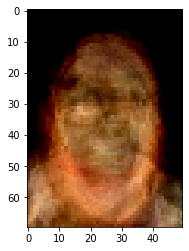

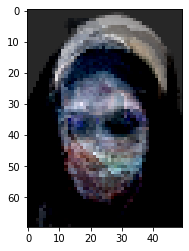

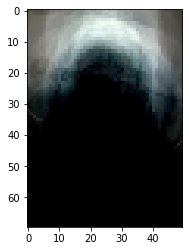

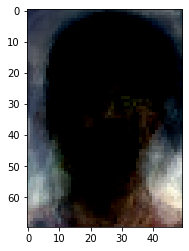

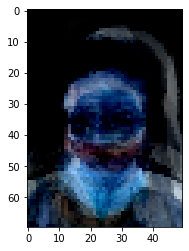

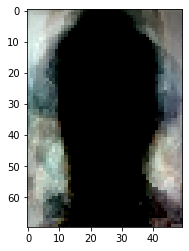

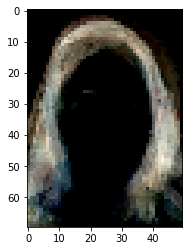

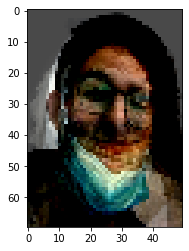

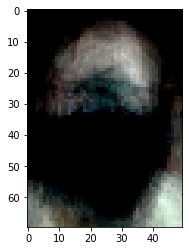

In [ ]:
# plotting first few left singular vectors as images for each category
for i in range(1,4):
  plt.imshow((u_p_dict['unmasked_nobg'][:,i]).reshape(70,50,3))
  plt.show()
  
  plt.imshow((u_p_dict['halfmasked_nobg'][:,i]).reshape(70,50,3))
  plt.show()

  plt.imshow((u_p_dict['correctly_masked_nobg'][:,i]).reshape(70,50,3))
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


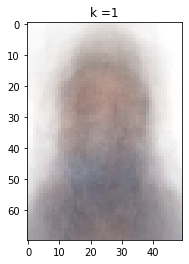

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


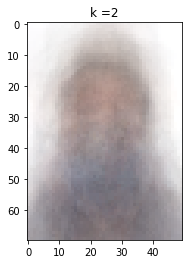

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


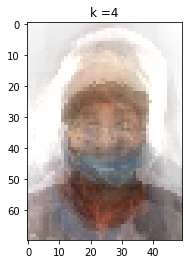

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


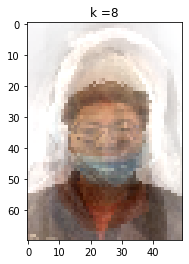

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


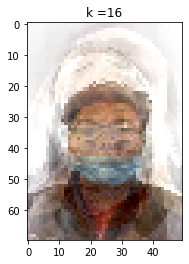

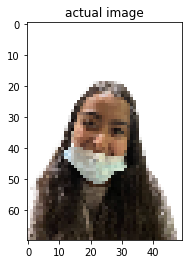

In [14]:
# function to find the image projection spanned by first k singular vectors
def projection(image, k, i):
  
  # find singular vectors corresponding to category
  category = category_lst[i]
  U = U_dict[category]
  proj = np.copy(im)
  
  # calculate projection
  for i in range(k):
    proj += (U[:,i]@(image - im))*U[:,i]
  return proj

# set k-values
k_lst = [1,2,4,8,16]
proj_lst = []

# average image
im = np.mean(A_train,axis=1)

# selecting single image from dataset for visualization
image = A_test[:,20].copy()

# find projection for each k
for k in k_lst:
  proj = projection(image, k, 1)
  proj_lst.append(proj)

# reshape flattened vectors into arrays and plot as image
for i in range(5):
  k = k_lst[i]
  plt.imshow((proj_lst[i]).reshape(70,50,3)/255)
  plt.title('k ='+str(k))
  plt.show()

# plot actual image for comparison
image = A_test[:,20].copy()/255
plt.imshow((image).reshape(70,50,3))
plt.title('actual image')
plt.show()

In [ ]:
# function to compute the distance of an image from projection
def dis(image, k):
  distance_lst = np.zeros(3)
  for i in range(3):
    distance = np.linalg.norm((image - projection(image, k, i)))**2 / (70*50)
    distance_lst[i] = distance
  return distance_lst

In [ ]:
L = len(y_test)
classification = np.zeros((L,21))

# iterate through k=1 to k=20
k_lst = np.arange(0,21)
for j in range(21):
  k = k_lst[j]

  # iterate through test images
  for i in range(L):
    image = A_test[:,i]

    # classify by finding smallest projection -> image distance
    classification[i, j] = np.argmin(dis(image, k))

# compute accuracy by comparing to actual labels
test_scores = []
for i in range(21):
  score = accuracy_score(y_test, classification[:,i])
  test_scores.append(score)

In [ ]:
# repeat clasification process for training data

A_train = np.concatenate((A_train_dict['unmasked_nobg'], A_train_dict['halfmasked_nobg'], A_train_dict['correctly_masked_nobg']), axis=1)
y_train = np.concatenate((y_train_dict['unmasked_nobg'], y_train_dict['halfmasked_nobg'], y_test_dict['correctly_masked_nobg']))

L = len(y_train)
classification = np.zeros((L,21))
k_lst = np.arange(0,21)
for j in range(21):
  k = k_lst[j]
  for i in range(L):
    image = A_train[:,i]
    classification[i, j] = np.argmin(dis(image, k))

train_scores = []
for i in range(21):
  train_score = accuracy_score(y_train, classification[:,i])
  train_scores.append(train_score)

In [ ]:
# computing recall and precision scores
recall_score(y_test, classification[:,13], average='weighted')
precision_score(y_test, classification[:,13])

0.532258064516129

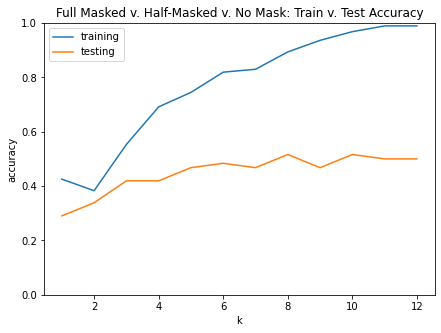

In [ ]:
# plot accuracy as k increases for training and testing data
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1,13),train_scores[:12], label='training')
plt.plot(np.arange(1,13),test_scores[:12], label='testing')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Full Masked v. Half-Masked v. No Mask: Train v. Test Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()